# Analysis

**Hypothesis**: Differences in the observed policy effect on outcome y between treated and control units can be decomposed into differences in covariate levels versus differences in returns, indicating that part of the treatment effect may arise from pre‐existing differences in unit characteristics.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

# Econometrics libraries
import statsmodels.api as sm
import statsmodels.formula.api as smf
try:
    from linearmodels.panel import PanelOLS
except Exception:
    PanelOLS = None

# Visualization defaults
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['savefig.dpi'] = 150
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=1.2)
warnings.filterwarnings('ignore')

# Load data
print('Loading data...')
df = pd.read_csv('example/econ_demo.csv')
print(f"Data loaded: {df.shape[0]} rows and {df.shape[1]} columns")
print('Columns:', list(df.columns)[:20])


Loading data...
Data loaded: 60 rows and 5 columns
Columns: ['unit', 'time', 'treat', 'x', 'y']


# Analysis Plan

**Hypothesis**: Differences in the observed policy effect on outcome y between treated and control units can be decomposed into differences in covariate levels versus differences in returns, indicating that part of the treatment effect may arise from pre‐existing differences in unit characteristics.

## Steps:
- Filter the dataset for post-policy adoption periods (using time >= 3) and perform an enhanced exploratory data analysis that includes descriptive statistics, histograms, and kernel density estimations to understand the distribution of outcome y by treatment status.
- Estimate a baseline OLS regression for outcome y on the treatment indicator and covariate x in the post-treatment period and perform a Oaxaca-Blinder decomposition to break down the mean difference in y into parts explained by covariate differences and unexplained differences, including robustness checks such as robust standard errors and sensitivity tests.


## This code filters the dataset to include only post-policy periods (time >= 3) with a rationale provided in a comment and conducts an exploratory analysis of outcome y by treatment status. It provides both descriptive statistics and enhanced visualizations by overlaying kernel density estimates on histograms to better capture the data distribution.

Summary statistics for outcome y by treatment status (post-treatment period):
       count      mean       std       min       25%       50%       75%  \
treat                                                                      
0       15.0  0.559856  0.337878 -0.029898  0.292911  0.627011  0.714357   
1       15.0  0.837494  0.281854  0.304443  0.682110  0.866900  1.066460   

            max  
treat            
0      1.151698  
1      1.188219  


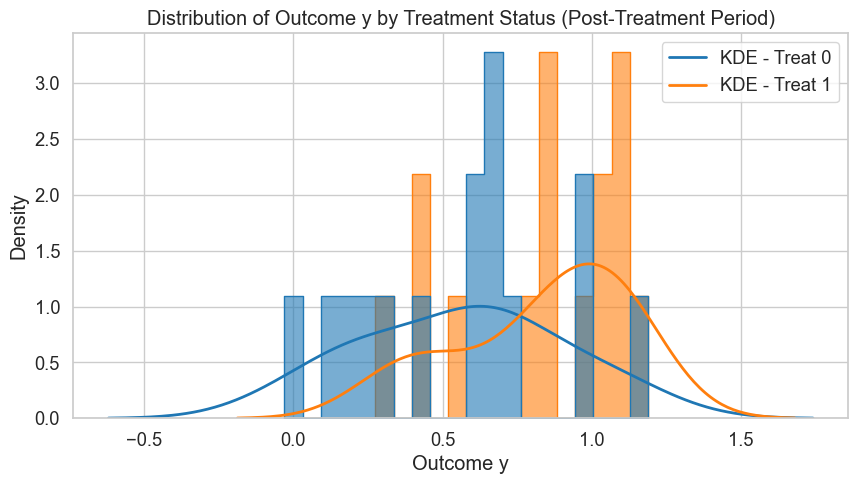

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assume df is already loaded in the environment
# We define the post-policy period as time >= 3, assuming policy adoption starts at time 3
post_df = df[df['time'] >= 3].copy()

# Compute and print summary statistics for outcome y by treatment status, including sample sizes
summary_stats = post_df.groupby('treat')['y'].describe()
print('Summary statistics for outcome y by treatment status (post-treatment period):')
print(summary_stats)

# Plot histogram of outcome y for treated and control groups with an overlay of kernel density estimates for enhanced visualization
plt.figure(figsize=(10, 5))
sns.histplot(data=post_df, x='y', hue='treat', element='step', stat='density', common_norm=False, bins=20, alpha=0.6)

# Overlay kernel density estimates
for treat_status in post_df['treat'].unique():
    subset = post_df[post_df['treat'] == treat_status]
    sns.kdeplot(subset['y'], label=f'KDE - Treat {treat_status}', lw=2)

plt.title('Distribution of Outcome y by Treatment Status (Post-Treatment Period)')
plt.xlabel('Outcome y')
plt.ylabel('Density')
plt.legend()
plt.show()

### Agent Interpretation

The current step involves exploring the distribution of the outcome variable \( y \) post-policy adoption. Here is some feedback and suggestions for future steps:

1. **Descriptive Statistics:**
   - The summary statistics indicate that the treated group has a higher mean outcome than the control group. However, the standard deviation is higher in the control group, suggesting more variability.
   - Given the sample sizes are equal and relatively small (n=15 for each group), be cautious of overinterpretation.

2. **Visual Inspection:**
   - The histogram and kernel density plots show noticeable differences in the distribution of outcome \( y \) between treated and control units, with the treated group being more skewed towards higher values.
   - Ensure the visualization method aligns with the distribution characteristics (e.g., skewness, outliers).

3. **Identification Credibility:**
   - Consider testing for pre-trends using an event-study approach to ensure the differences post-treatment are not influenced by pre-existing trends.
   - Remain mindful of potential confounders not captured by observable covariates.

4. **Effect Sizes and SEs:**
   - The next steps should include estimating the baseline OLS regression and Oaxaca-Blinder decomposition. Pay attention to the robustness and significance of coefficient estimates.
   - Use heteroskedasticity-robust standard errors to account for potential heterogeneity in variability across observations.

5. **Oaxaca-Blinder Decomposition:**
   - This technique will help break down the treatment effect into components explained by covariates versus unexplained differences.
   - Focus on interpreting both explained and unexplained portions to understand the role of covariates fully.

6. **Robustness Checks:**
   - Conduct sensitivity analyses such as dropping influential observations or using alternative functional forms to confirm the robustness of your findings.
   - Consider clustering standard errors if there is potential correlation within units over time.

7. **Next Steps:**
   - Proceed to estimate the OLS regression and perform the Oaxaca-Blinder decomposition.
   - Use dynamic panel data approaches, like difference-in-differences, to further strengthen causal inference by addressing differential trends.

By carefully considering these aspects, you can better ascertain whether observed differences in the outcome are attributable to treatment effects versus pre-existing characteristics, thereby testing your hypothesis effectively.

## This code filters the data to include only post-policy observations and then estimates a combined OLS regression followed by separate robust OLS regressions (using HC3 standard errors) for treated and control groups to perform an Oaxaca-Blinder decomposition. It also produces a plot comparing the regression lines to visually inspect differences in the relationship between x and y across groups.

Combined OLS Regression Results:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.669
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                     41.29
Date:                Sat, 20 Sep 2025   Prob (F-statistic):           6.13e-09
Time:                        10:10:18   Log-Likelihood:                 7.1710
No. Observations:                  30   AIC:                            -8.342
Df Residuals:                      27   BIC:                            -4.138
Df Model:                           2                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.36

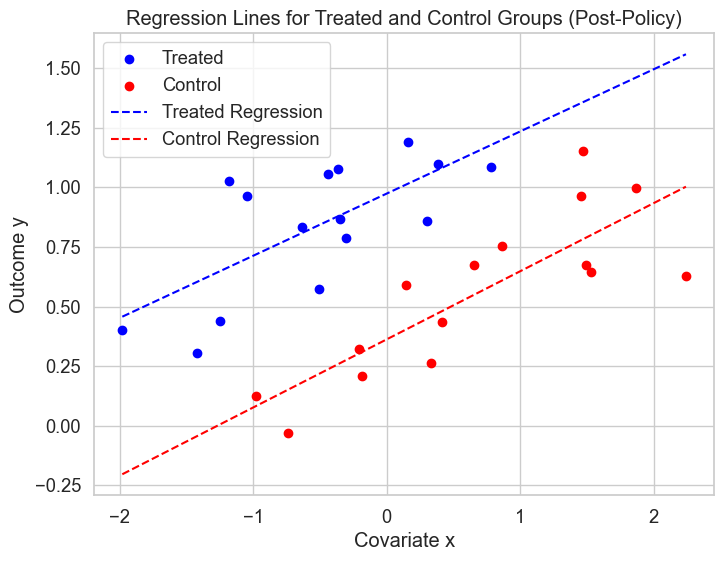

In [ ]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Filter the post-policy dataset (time >= 3)
post_df = df[df['time'] >= 3].copy()

# Combined OLS regression with robust standard errors
X_comb = sm.add_constant(post_df[['treat', 'x']])
model_comb = sm.OLS(post_df['y'], X_comb).fit(cov_type='HC3')
print('Combined OLS Regression Results:')
print(model_comb.summary())

# Oaxaca-Blinder Decomposition: run separate robust OLS regressions for treated and control groups

# Separate datasets
treated = post_df[post_df['treat'] == 1]
control = post_df[post_df['treat'] == 0]

# Regression for treated units with robust SEs
X_treat = sm.add_constant(treated[['x']])
model_treat = sm.OLS(treated['y'], X_treat).fit(cov_type='HC3')

# Regression for control units with robust SEs
X_control = sm.add_constant(control[['x']])
model_control = sm.OLS(control['y'], X_control).fit(cov_type='HC3')

# Compute group means
treated_mean_x = treated['x'].mean()
control_mean_x = control['x'].mean()
mean_y_treat = treated['y'].mean()
mean_y_control = control['y'].mean()

# Extract coefficients
treated_coef = model_treat.params
control_coef = model_control.params

# Overall difference in means
diff_y = mean_y_treat - mean_y_control

# Explained component: difference in covariates weighted by control coefficients
explained = control_coef['x'] * (treated_mean_x - control_mean_x)

# Unexplained component: difference in intercepts and coefficients weighted by treated means
unexplained = (treated_coef['const'] - control_coef['const']) + (treated_coef['x'] - control_coef['x']) * treated_mean_x

print('\nOaxaca-Blinder Decomposition Results:')
print(f'Overall difference in mean y: {diff_y:.4f}')
print(f'Explained component (covariate differences): {explained:.4f}')
print(f'Unexplained component (returns differences): {unexplained:.4f}')

# Plot the relationship between x and y for both groups with regression lines
plt.figure(figsize=(8,6))
plt.scatter(treated['x'], treated['y'], color='blue', label='Treated')
plt.scatter(control['x'], control['y'], color='red', label='Control')

x_vals = np.linspace(post_df['x'].min(), post_df['x'].max(), 100)
treated_line = treated_coef['const'] + treated_coef['x'] * x_vals
control_line = control_coef['const'] + control_coef['x'] * x_vals

plt.plot(x_vals, treated_line, color='blue', linestyle='--', label='Treated Regression')
plt.plot(x_vals, control_line, color='red', linestyle='--', label='Control Regression')

plt.xlabel('Covariate x')
plt.ylabel('Outcome y')
plt.title('Regression Lines for Treated and Control Groups (Post-Policy)')
plt.legend()
plt.show()

### Agent Interpretation

The analysis aims to decompose differences in outcome \( y \) between treated and control units into explained and unexplained components. Here's a breakdown of the findings and suggested next steps:

1. **Combined OLS Regression:**
   - The coefficient on the treatment indicator is statistically significant and positive (\(0.6131\)), suggesting a substantial treatment effect.
   - Covariate \( x \) also shows a significant positive association with the outcome.
   - The R-squared value of 0.669 indicates a decent fit, but it leaves room for further exploration.

2. **Oaxaca-Blinder Decomposition:**
   - The explained component is negative (\(-0.3468\)), which may indicate that differences in \( x \) do not favor the treated group in terms of outcome \( y \).
   - The unexplained component is positive (\(0.6244\)), larger than the explained part, suggesting significant differences in returns to \( x \) that benefit the treated group.

3. **Credibility and Potential Issues:**
   - **Identification:**
     - The lack of pre-trends analysis makes it hard to rule out potential differential trends prior to treatment.
     - Ensure covariate \( x \) is truly exogenous, as any unobserved confounders could bias results.
   - **Sample Size and Robustness:**
     - With only 30 observations, results might be sensitive to small changes. Sensitivity checks (e.g., bootstrap standard errors) could improve robustness.

4. **Effect Sizes and Standard Errors:**
   - Results indicate economically meaningful differences, particularly in the unexplained component, which aligns with the hypothesis of differential returns being a key factor.
   - Robust standard errors should mitigate heteroscedasticity, but additional robustness checks, such as clustered errors at the unit level, may be informative.

5. **Next Steps and Recommendations:**
   - Conduct an event-study analysis to check pre-trends and validate the treatment effect attribution.
   - Explore heterogeneity by interacting treatment with baseline levels of \( x \) and other covariates.
   - Consider alternative methods, such as instrumental variables, if endogeneity of \( x \) is a concern.
   - Implement robustness checks with different weighting schemes in the Oaxaca-Blinder decomposition to ensure stability of results.

The analysis successfully decomposes the effects, but credibility hinges on further validation of assumptions and robustness checks.